<div style="border:solid green 2px; padding: 20px">
Светлана, привет и хорошего дня! <br>
Меня зовут Сергей Дроздов, и я буду проверять твой проект. Предлагаю общаться на «ты». Если тебе удобнее общаться на "Вы", просто дай знать. 

Ты уже проделал большую работу над проектом, но давай сделаем его еще лучше. Ниже ты найдешь мои комментарии - пожалуйста, не перемещай, не изменяй и не удаляй их. Я буду использовать цветовую разметку:

<div class="alert alert-danger">
<b>Комментарий ревьюера: &#10060; </b> Так будут выделены комментарии с указаниями, обязательными к выполнению. Без их выполнения проект не будет принят. </div>

<div class="alert alert-warning">
<b>Комментарий ревьюера:
&#9888;</b> Так будут выделены некритичные замечания. Их отработка позволит улучшить качество твоего проекта.
</div>

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Так будут выделены остальные комментарии, полезные лайфхаки и ссылки на сторонние ресурсы </div>

Для наиболее эффективной и оперативной работы над проектом, мне хотелось бы иметь обратную связь. Не стесняйся задавать вопросы. Если ты что-либо меняешь в проекте, пожалуйста, комментируй это. Мне будет легче отследить изменения, если ты выделишь свои комментарии:
<div class="alert alert-info"> <b>Комментарий студента:</b> Например вот так</div>

# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

**Заказчик** — сеть отелей «Как в гостях». Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

**Цель данного исследования**: разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предложат внести депозит (размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку). Деньги будут списаны со счёта клиента, если он всё же отменит бронь. 

На разработку системы прогнозирования заложен **бюджет** — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

**Ход работы**:
1. [Предобработка и EDA](#preprocessing)
2. [Оценка прибыли отеля](#profit)
3. [Разработка ML модели](#ml_model)
4. [Описание "ненадежного" клиента](#client)
5. [Выводы](#conclusion)

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! </div>

<a id="preprocessing"></a>
### Шаг 1. Откройте файлы с данными

In [1]:
# доп.библиотеки
!pip install imbalanced-learn -q

In [2]:
# импорты
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
# данные для обучения модели
train_data = pd.read_csv('/datasets/hotel_train.csv')
# данные для тестирования модели
test_data = pd.read_csv('/datasets/hotel_test.csv')

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Ок, данные на базе! </div>

In [4]:
train_data.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


**Описание данных:**

В таблицах *hotel_train* и *hotel_test* содержатся одинаковые столбцы:
- `id` — номер записи;
- `adults`  — количество взрослых постояльцев;
- `arrival_date_year` — год заезда;
- `arrival_date_month` — месяц заезда;
- `arrival_date_week_number` — неделя заезда;
- `arrival_date_day_of_month` — день заезда;
- `babies` — количество младенцев;
- `booking_changes` — количество изменений параметров заказа;
- `children` — количество детей от 3 до 14 лет;
- `country` — гражданство постояльца;
- `customer_type`  — тип заказчика:
    - *Contract* — договор с юридическим лицом;
    - *Group* — групповой заезд;
    - *Transient* — не связано с договором или групповым заездом;
    - *Transient-party* — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
- `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
- `distribution_channel` — канал дистрибуции заказа;
- `is_canceled` — отмена заказа;
- `is_repeated_guest` — признак того, что гость бронирует номер второй раз;
- `lead_time` — количество дней между датой бронирования и датой прибытия;
- `meal` — опции заказа:
    - *SC* — нет дополнительных опций;
    - *BB* — включён завтрак;
    - *HB* — включён завтрак и обед;
    - *FB* — включён завтрак, обед и ужин.
- `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
- `previous_cancellations` — количество отменённых заказов у клиента;
- `required_car_parking_spaces` — необходимость места для автомобиля;
- `reserved_room_type`  — тип забронированной комнаты;
- `stays_in_weekend_nights` — количество ночей в выходные дни;
- `stays_in_week_nights` — количество ночей в будние дни;
- `total_nights` — общее количество ночей;
- `total_of_special_requests` — количество специальных отметок.

<a id="preprocessing"></a>
### Шаг 2. Предобработка и исследовательский анализ данных

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

Пропусков ни в датасете для обучения, ни в датасете для финального тестирования модели не наблюдается. При этом, объем второго датасета примерно в два раза меньше. Количество столбцов совпадает.

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! </div>

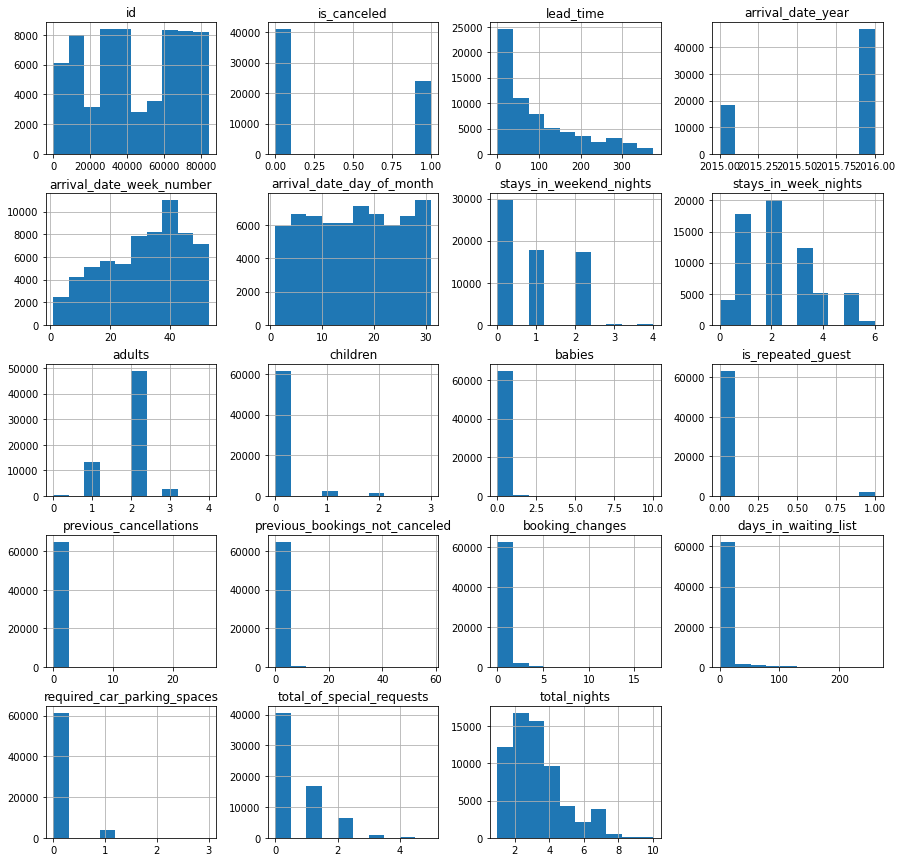

In [7]:
# гистограммы численных признаков
train_data.hist(figsize=(15, 15))
plt.show()

Среди численных признаков можно выделить два бинарных: *is_canceled* (целевая переменная!) и *is_repeated_quest*. Остальные же из перечисленных должны относиться к целочисленному типу. Несоответствие наблюдается только для *lead_time*, *adults*, *children*, *babies*.

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Хорошо! </div>

In [8]:
numeric = ['lead_time', 'adults', 'children', 'babies']

train_data[numeric] = train_data[numeric].astype(int)
test_data[numeric] = test_data[numeric].astype(int)

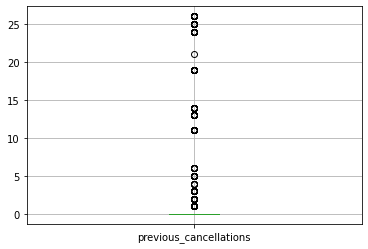

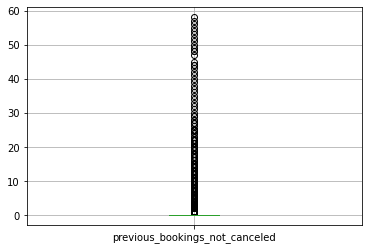

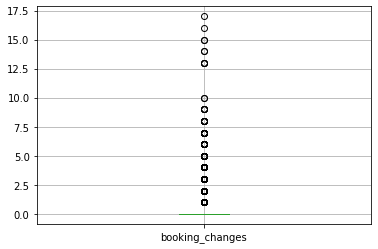

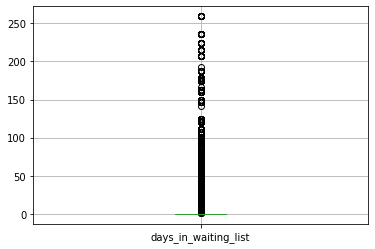

In [9]:
# "ящик с усами" для подозрительных признаков
train_data.boxplot('previous_cancellations')
plt.show()

train_data.boxplot('previous_bookings_not_canceled')
plt.show()

train_data.boxplot('booking_changes')
plt.show()

train_data.boxplot('days_in_waiting_list')
plt.show()

Распределения численных признаков тоже выглядят логично. В столбцах *previious_cancellations*, *previous_booking_not_canceled*, *booking_changes* и *days_in_wayting_list* встречаются редкие значения, отдаленные от 0, однако, они выглядят реалистично и, возможно, будут полезны для вычислений модели. Удалять их не будем. А вот 9-10 младенцев в семье (столбец *babies*) - уже подозрительно.

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! </div>

In [10]:
train_data['babies'].value_counts()

0     64777
1       447
2         3
9         1
10        1
Name: babies, dtype: int64

9-10 маленьких детей у постояльцев - это всего 2 случая в тренировочном датафрейме. Однозначно, это выбросы. Удаляем.

In [11]:
train_data = train_data.loc[train_data['babies'] < 9]

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! </div>

Данные с нулевым количеством взрослых будем считать некорректными, поскольку дети забронировать номер без взрослых не могут и в номере обязательно должен жить хотя бы один человек.

In [12]:
# строк с нулевым количеством взрослых
train_data.query('adults == 0')['adults'].count()

166

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Супер! </div>

In [13]:
train_data = train_data.loc[train_data['adults'] != 0]

Также в датафрейме имеется числовой столбец, содержащий суммарное количество ночей. Логичным является предположение, что он будет содержать сумму столбцов с количеством ночей в будние дни и в выходные. Проверим.

In [14]:
train_data.query('total_nights != stays_in_weekend_nights + stays_in_week_nights')

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


Это действительно так. Поскольку признак является производным от двух других, его также можно удалить из датафрейма.

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! </div>

In [15]:
train_data.drop('total_nights', axis=1, inplace=True)
test_data.drop('total_nights', axis=1, inplace=True)

Оставшиеся столбцы *arrival_date_month*, *customer_type*, *distribution_channel*, *meal*, *reserved_room_type*, *country* относятся к категориальным. Проверим значения в них на неявные дубликаты.

In [16]:
train_data['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [17]:
train_data['customer_type'].unique()

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

In [18]:
train_data['distribution_channel'].unique()

array(['Direct', 'TA/TO', 'Corporate', 'GDS'], dtype=object)

In [19]:
train_data['country'].unique()

array(['GBR', 'PRT', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'USA', 'DEU',
       'BEL', 'CHE', 'CN', 'GRC', 'NLD', 'ARG', 'RUS', 'SWE', 'POL',
       'EST', 'CZE', 'ITA', 'FIN', 'DNK', 'MOZ', 'BWA', 'LUX', 'BRA',
       'SVN', 'ALB', 'CHN', 'MEX', 'MAR', 'SMR', 'LVA', 'CHL', 'AUT',
       'LTU', 'TUR', 'ISR', 'IND', 'CYM', 'AUS', 'CPV', 'ZWE', 'DZA',
       'KOR', 'CRI', 'HUN', 'TUN', 'ARE', 'HRV', 'HKG', 'IRN', 'GIB',
       'JEY', 'URY', 'ZAF', 'COL', 'GGY', 'KWT', 'CYP', 'KAZ', 'THA',
       'DOM', 'NGA', 'BLR', 'VEN', 'UKR', 'ARM', 'JPN', 'LKA', 'MYS',
       'BIH', 'MUS', 'OMN', 'SUR', 'JAM', 'BGR', 'CIV', 'SRB', 'JOR',
       'SYR', 'PHL', 'PRI', 'SGP', 'BDI', 'LBN', 'AGO', 'VNM', 'AZE',
       'PLW', 'NZL', 'EGY', 'MDV', 'CMR', 'MLT', 'SVK', 'MWI', 'STP',
       'TWN', 'IDN', 'SEN', 'PER', 'SAU', 'KNA', 'ETH', 'ECU', 'IRQ',
       'AND', 'HND', 'PAK', 'GEO', 'ZMB', 'QAT', 'KHM', 'MCO', 'BGD',
       'ISL', 'UZB', 'IMN', 'TJK', 'NIC', 'BEN', 'MAC', 'VGB', 'TZA',
       'GAB', 'MKD', 

In [20]:
train_data['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

In [21]:
train_data['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

В столбце *country* очень много уникальных значений, однако, все они записаны в одном стиле. Гражданство может оказаться важным показателем, поэтому удалять его не будем.

В последних двух столбцах значения кроме самого наименования категории содержат также некоторое количество пробелов. Для чистоты эксперимента лишние пробелы необходимо удалить.

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! </div>

In [22]:
train_data['meal'] = train_data['meal'].str.strip()
test_data['meal'] = test_data['meal'].str.strip()

train_data['meal'].unique(), test_data['meal'].unique()

(array(['BB', 'FB', 'HB', 'SC'], dtype=object),
 array(['BB', 'HB', 'SC', 'FB'], dtype=object))

In [23]:
train_data['reserved_room_type'] = train_data['reserved_room_type'].str.strip()
test_data['reserved_room_type'] = test_data['reserved_room_type'].str.strip()

train_data['reserved_room_type'].unique(), test_data['reserved_room_type'].unique()

(array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object),
 array(['A', 'E', 'G', 'D', 'F', 'C', 'B'], dtype=object))

Проверка на полные дубликаты:

In [24]:
train_data.duplicated().sum(), test_data.duplicated().sum()

(0, 0)

Явных дубликатов не обнаружено. Однако они могут появиться при удалении столбца *id* (для обучения модели он ценности не представляет).

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! </div>

In [25]:
train_data = train_data.drop('id', axis=1)
test_data = test_data.drop('id', axis=1)

In [26]:
# новая проверка на полные дубликаты
train_data.duplicated().sum(), test_data.duplicated().sum()

(21375, 7717)

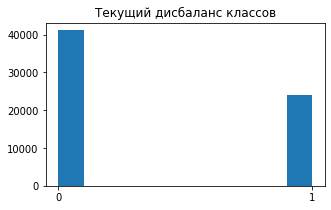

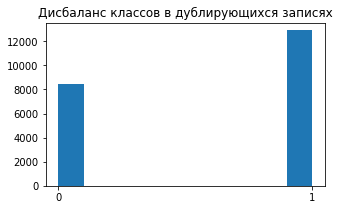

In [27]:
train_data['is_canceled'].astype(str).hist(figsize=(5, 3), grid=False)
plt.title('Текущий дисбаланс классов')
plt.show()

train_data[train_data.duplicated()]['is_canceled'].astype(str).hist(figsize=(5, 3), grid=False)
plt.title('Дисбаланс классов в дублирующихся записях')
plt.show()

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! </div>

Повторяющиеся записи бесполезны, однако, составляют примерно треть всего датафрейма (!). К тому же, их удаление поспособствует уменьшению записей с положительным классом (дисбаланс классов станет более ярко выражен). Поэтому оставим их в наборе.

Поскольку модель будет использоваться для прогнозирования только новых бронирований, оставлять в датасете столбец с годом заезда не имеет смысла. Дату заезда и номер недели также следует удалить: день заезда на целевой признак не влияет, а распределение по номерам недель должно иллюстрировать ту же сезонность, что и распределение отмен по месяцам.

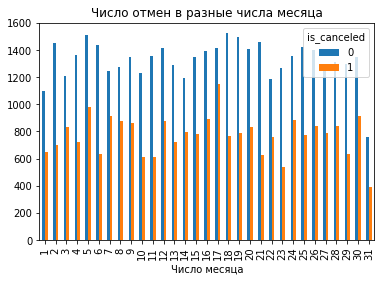

In [28]:
pd.crosstab(train_data.arrival_date_day_of_month, train_data.is_canceled).plot(kind='bar', xlabel='Число месяца')
plt.title('Число отмен в разные числа месяца')
plt.show()

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! </div>

In [29]:
train_data = train_data.drop(['arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month'], axis=1)
test_data = test_data.drop(['arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month'], axis=1)

Подробное разбиение по месяцам тоже не особо нужно: гораздо важнее знать сезон, который определяет сезонные коэффициенты.

In [30]:
# соответствие сезона месяцу
def get_season(month):
    if month in ['June', 'July', 'August']:
        return 'Summer'
    elif month in ['September', 'October', 'November']:
        return 'Autumn'
    elif month in ['December', 'January', 'February']:
        return 'Winter'
    elif month in ['March', 'April', 'May']:
        return 'Spring'

In [31]:
train_data['season'] = train_data['arrival_date_month'].apply(get_season)
test_data['season'] = test_data['arrival_date_month'].apply(get_season)

train_data.drop('arrival_date_month', axis=1, inplace=True)
test_data.drop('arrival_date_month', axis=1, inplace=True)

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Хорошо! </div>

In [32]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65061 entries, 0 to 65228
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   is_canceled                     65061 non-null  int64 
 1   lead_time                       65061 non-null  int64 
 2   stays_in_weekend_nights         65061 non-null  int64 
 3   stays_in_week_nights            65061 non-null  int64 
 4   adults                          65061 non-null  int64 
 5   children                        65061 non-null  int64 
 6   babies                          65061 non-null  int64 
 7   meal                            65061 non-null  object
 8   country                         65061 non-null  object
 9   distribution_channel            65061 non-null  object
 10  is_repeated_guest               65061 non-null  int64 
 11  previous_cancellations          65061 non-null  int64 
 12  previous_bookings_not_canceled  65061 non-null

In [33]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   is_canceled                     32412 non-null  int64 
 1   lead_time                       32412 non-null  int64 
 2   stays_in_weekend_nights         32412 non-null  int64 
 3   stays_in_week_nights            32412 non-null  int64 
 4   adults                          32412 non-null  int64 
 5   children                        32412 non-null  int64 
 6   babies                          32412 non-null  int64 
 7   meal                            32412 non-null  object
 8   country                         32412 non-null  object
 9   distribution_channel            32412 non-null  object
 10  is_repeated_guest               32412 non-null  int64 
 11  previous_cancellations          32412 non-null  int64 
 12  previous_bookings_not_canceled  32412 non-null

Таким образом, в наборах с данными осталось по 20 столбцов (один из которых - целевой) либо с целочисленным т. Количество строк снизилось незначительно. Перед обучением модели дополнительно необходимо будет стандартизировать численные признаки и закодировать оставшиеся категориальные.

In [34]:
features_train = train_data.drop('is_canceled', axis=1)
target_train = train_data['is_canceled']

features_test = test_data.drop('is_canceled', axis=1)
target_test = test_data['is_canceled']

In [35]:
# масштабирование
numeric = features_train.select_dtypes(include='int64').columns.to_list()
numeric.remove('is_repeated_guest') # бинарный признак

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [36]:
# кодирование нечисловых столбцов (OHE)
categorical = ['meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type', 'season']
enc = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore') # неизвестные категории будут столбцами с 0
enc.fit(features_train[categorical])

# наименования столбцов
ohe_column_names = enc.get_feature_names_out(categorical)                

# train
encoded_train = pd.DataFrame(enc.transform(features_train[categorical]), index=features_train.index, columns=ohe_column_names)
features_train = pd.concat([features_train, encoded_train], axis=1)

# test
encoded_test = pd.DataFrame(enc.transform(features_test[categorical]), index=features_test.index, columns=ohe_column_names)
features_test = pd.concat([features_test, encoded_test], axis=1)

display(features_train.head())
display(features_test.head())

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,...,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,season_Spring,season_Summer,season_Winter
0,-0.928977,-0.966529,-0.903334,-1.783139,-0.219336,-0.0829,BB,GBR,Direct,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.856193,-0.966529,-0.165486,0.336436,-0.219336,-0.0829,BB,GBR,TA/TO,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-1.001761,-0.966529,-0.165486,0.336436,-0.219336,-0.0829,BB,PRT,Direct,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-0.908181,-0.966529,-0.165486,0.336436,-0.219336,-0.0829,FB,PRT,Direct,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.117955,-0.966529,0.572362,0.336436,-0.219336,-0.0829,BB,PRT,TA/TO,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,...,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,season_Spring,season_Summer,season_Winter
0,-0.232330,0.205356,-1.641182,0.336436,-0.219336,-0.0829,BB,PRT,TA/TO,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.357102,1.377241,-0.165486,0.336436,-0.219336,-0.0829,BB,AUT,TA/TO,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.357102,1.377241,-0.165486,0.336436,-0.219336,-0.0829,BB,AUT,TA/TO,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-0.263523,1.377241,-0.165486,-1.783139,-0.219336,-0.0829,BB,PRT,TA/TO,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.786647,1.377241,2.048058,0.336436,-0.219336,-0.0829,BB,BEL,TA/TO,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично!  </div>

In [37]:
# удаление старых столбцов
features_train = features_train.drop(columns=categorical)
features_test = features_test.drop(columns=categorical)

Дисбаланс классов:

In [38]:
# в долях
target_train.value_counts(normalize=True)

0    0.631177
1    0.368823
Name: is_canceled, dtype: float64

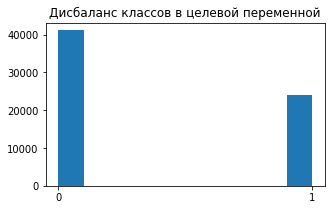

In [39]:
target_train.astype(str).hist(figsize=(5, 3), grid=False)
plt.title('Дисбаланс классов в целевой переменной')
plt.show()

В данных наблюдается достаточно ярко выраженный дисбаланс отрицательного класса. Используем технику SMOTE, т.е. синтетически увеличим содержание положительного класса.

In [40]:
# работа с дисбалансом
smote = SMOTE(random_state=123)
features_train, target_train = smote.fit_resample(features_train, target_train)

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Молодец, что используешь SMOTE для борьбы с дисбалансом </div>

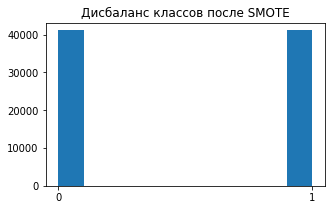

In [41]:
target_train.astype(str).hist(figsize=(5, 3), grid=False)
plt.title('Дисбаланс классов после SMOTE')
plt.show()

Таким образом, данные готовы к обучению: численные признаки стандартизированы, категориальные признаки закодированы методом OHE, дисбаланс классов устранен. Итоговый размер обучающей выборки:

In [42]:
features_train.shape

(82130, 185)

<a id="profit"></a>
### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Оценим прибыль отеля без внедрения депозитов. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 

*Стоимость номеров отеля:*
- категория A: за ночь — 1 000, разовое обслуживание — 400
- категория B: за ночь — 800, разовое обслуживание — 350
- категория C: за ночь — 600, разовое обслуживание — 350
- категория D: за ночь — 550, разовое обслуживание — 150
- категория E: за ночь — 500, разовое обслуживание — 150
- категория F: за ночь — 450, разовое обслуживание — 150
- категория G: за ночь — 350, разовое обслуживание — 150

В ценовой политике отеля используются *сезонные коэффициенты*: весной и осенью цены повышаются на 20%, летом — на 40%. Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

Оценку прибыли будем проводить на тестовом датасете. Создадим новые столбцы, чтобы было удобнее проводить расчет.

In [43]:
# копия датасета с тестовыми данными
profit_df = test_data.copy(deep=True)

In [44]:
profit_df.columns

Index(['is_canceled', 'lead_time', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
       'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'season'],
      dtype='object')

In [45]:
# словарь с условиями для разных номеров
# [стоимость ночи, стоимость уборки]
room_type_dict = {
    'A': [1000, 400],
    'B': [800, 350],
    'C': [600, 350],
    'D': [550, 150],
    'E': [500, 150],
    'F': [450, 150],
    'G': [350, 150]
}

In [46]:
# возвращает стоимость номера и затраты на уборку
def get_room_params(room_type):
    return room_type_dict[room_type]

In [47]:
# возвращает сезонный коэффициент
def get_factor(season):
    if season == 'Summer': 
        return 1.4
    elif season == 'Winter': 
        return 1
    
    return 1.2

In [48]:
# возвращает прибыль от бронирования в зависимости от категории номера
def get_profit(nights, season, room_type, is_canceled=False): 
    factor = get_factor(season)                 # вычисление сезонного коэффициента  
    cost, service = get_room_params(room_type)  # вычисление параметров номера
    
    # расчет прибыли
    if is_canceled:
        return -(cost + service)*factor
    
    else:
        return (cost*nights - service*(nights//2+1))*factor

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! </div>

In [49]:
# применение функции к датафрейму
def profit_row(row):
    nights = row['stays_in_week_nights'] + row['stays_in_weekend_nights'] # общее количество ночей
    row['profit'] = get_profit(nights, row['season'], row['reserved_room_type'], bool(row['is_canceled']))
    
    return row

In [50]:
# проверка функции
test_df = profit_df.loc[[0, 2501, 16000], 
                        ['reserved_room_type', 'stays_in_week_nights', 'stays_in_weekend_nights', 'season', 'is_canceled']
                       ].copy()

test_df['profit'] = 0
test_df = test_df.apply(profit_row, axis=1)

test_df

,reserved_room_type,stays_in_week_nights,stays_in_weekend_nights,season,is_canceled,profit
0,A,0,1,Winter,1,-1400.0
2501,G,1,0,Spring,0,240.0
16000,D,2,0,Summer,1,-980.0


In [51]:
test_df['profit'].dtype

dtype('float64')

**Ручной подсчет:** \
`0`: отмена бронирования -> вычисляем только убытки (ночь 1000 + обслуживание 400) для категории номера А = -1400 \
`2501`: подтверждено -> вычисляем прибыль: 1 ночь в комнате G (350) - уборка (150), весной (коэффициент 20%) = 240 \
`16000`: отмена -> вычисляем убытки (ночь 550 + обслуживание 150) для категории D летом (коэффициент 40%) = -980

Расчеты верны, можно применить ко всему датафрейму и вычислить прибыль.

In [52]:
profit_df['profit'] = 0
profit_df = profit_df.apply(profit_row, axis=1)

print('Прибыль без введения депозитов:', profit_df['profit'].sum())

Прибыль без введения депозитов: 28257360.0


Таким образом, необходимо создать модель, которая бы как можно точнее определяла клиентов, которые отменят бронь - так мы минимизируем убытки и увеличим общую прибыль. Для такой задачи лучше всего подойдет метрика *recall* (или *полнота*). 

<a id="ml_model"></a>
### Шаг 4. Разработка модели ML

Сравним модели, обученные тремя самыми известными алгоритмами классификации - *kNN*, *Random Forest* и *Logistic regression*. Оценивать качество моделей будем с использованием кросс-валидации для получения более уравновешенных результатов. 

In [53]:
%%time

# Random Forest
best_score, best_n, best_depth = 0, 1, 1
for n in range(1, 50, 5):
    for depth in range(1, 12):
        model = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=12345)
        scores = cross_val_score(model, features_train, target_train, scoring='recall', cv=5)
        score = scores.mean()
        
        if score > best_score:
            best_score = score
            best_n, best_depth = n, depth

print(f'best_score = {round(best_score, 3)} при {best_n} деревьев с максимальной глубиной {best_depth}')

best_score = 0.791 при 11 деревьев с максимальной глубиной 2
CPU times: user 6min 58s, sys: 30.6 s, total: 7min 29s
Wall time: 7min 29s


In [54]:
%%time

# Logistic regession
solver_list = ['newton-cg', 'lbfgs', 'liblinear']
best_score, best_solver = 0, ''

for solver in solver_list:
    model = LogisticRegression(solver=solver)
    scores = cross_val_score(model, features_train, target_train, scoring='recall', cv=5)
    score = scores.mean()
    
    if score > best_score:
        best_score = score
        best_solver = solver
        
print(f'best_score = {round(best_score, 3)} при solver={best_solver}')

best_score = 0.744 при solver=liblinear
CPU times: user 3min 47s, sys: 1min 44s, total: 5min 32s
Wall time: 5min 33s


Лучше всего показала себя **модель случайного леса** с 11 деревьями в ансамбле с максимальной глубиной дерева = 2 . Значение метрики recall, полученное кросс-валидацией = **0.791**. Т.е. модель способна определить 4/5 клиентов, которые отменят бронь. Посмотрим, насколько хорошо она сможет предсказать отмену бронирования на тестовых данных.

In [55]:
forest_model = RandomForestClassifier(n_estimators=11, max_depth=2, random_state=12345)
forest_model.fit(features_train, target_train)
f_predictions = forest_model.predict(features_test)

print(recall_score(target_test, f_predictions))

0.6643634341990311


<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Молодец, что проверяешь только итоговую модель на тестовой выборке! </div>

Рассчитаем прибыль отеля после внедрения модели:

In [56]:
predicted_data = pd.concat([profit_df, pd.DataFrame(f_predictions)], axis=1)
predicted_data.rename(columns={0: 'predict'}, inplace=True)
predicted_data.head()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,...,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,season,profit,predict
0,1,74,1,0,2,0,0,BB,PRT,TA/TO,...,0,A,0,0,Transient,0,0,Winter,-1400.0,1
1,1,62,2,2,2,0,0,BB,AUT,TA/TO,...,0,A,0,0,Transient,0,1,Winter,-1400.0,0
2,1,62,2,2,2,0,0,BB,AUT,TA/TO,...,0,A,0,0,Transient,0,1,Winter,-1400.0,0
3,1,71,2,2,1,0,0,BB,PRT,TA/TO,...,0,A,0,0,Transient,0,1,Winter,-1400.0,1
4,1,172,2,5,2,0,0,BB,BEL,TA/TO,...,0,A,0,0,Transient,0,0,Winter,-1400.0,1


Прибыль изменится только в том случае, когда модель предсказала, что клиент отменит бронь и он ее действительно отменил: убытки снизятся на 80%. Если модель предсказала, что бронь отменят, а ее не отменили - отель ничего не потеряет. Если наоборот - убытки останутся теми же.

In [57]:
# изменяет прибыль, если модель предсказала отмену
def change_profit(row):
    if row['is_canceled'] == 1 and row['predict'] == 1:
        row['predicted_profit'] = row['profit'] * 0.2
    
    return row

In [58]:
predicted_data['predicted_profit'] = predicted_data['profit']
predicted_data = predicted_data.apply(change_profit, axis=1)
predicted_data.head()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,...,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,season,profit,predict,predicted_profit
0,1,74,1,0,2,0,0,BB,PRT,TA/TO,...,A,0,0,Transient,0,0,Winter,-1400.0,1,-280.0
1,1,62,2,2,2,0,0,BB,AUT,TA/TO,...,A,0,0,Transient,0,1,Winter,-1400.0,0,-1400.0
2,1,62,2,2,2,0,0,BB,AUT,TA/TO,...,A,0,0,Transient,0,1,Winter,-1400.0,0,-1400.0
3,1,71,2,2,1,0,0,BB,PRT,TA/TO,...,A,0,0,Transient,0,1,Winter,-1400.0,1,-280.0
4,1,172,2,5,2,0,0,BB,BEL,TA/TO,...,A,0,0,Transient,0,0,Winter,-1400.0,1,-280.0


In [59]:
profit_before = predicted_data["profit"].sum()
profit_after = predicted_data["predicted_profit"].sum()

print(f'Прибыль ДО: {profit_before}')
print(f'Прибыль ПОСЛЕ: {profit_after}')
print(f'Разница составит: {profit_after - profit_before}')

Прибыль ДО: 28257360.0
Прибыль ПОСЛЕ: 38569488.0
Разница составит: 10312128.0


Таким образом, внедрение модели и системы депозитов позволит увеличить прибыль отеля на 10 млн рублей, что с избытком покроет затраты на разработку модели (400 тыс.руб.).

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! </div>

<a id="client"></a>
### Шаг 5. Опишите портрет «ненадёжного» клиента

Попробуем определить, есть ли в данных признаки, которые бы существенно отличали надежного клиента от "ненадежного".

In [60]:
train_data.columns

Index(['is_canceled', 'lead_time', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
       'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'season'],
      dtype='object')

In [61]:
train_data['is_canceled'] = train_data['is_canceled'].astype(bool)

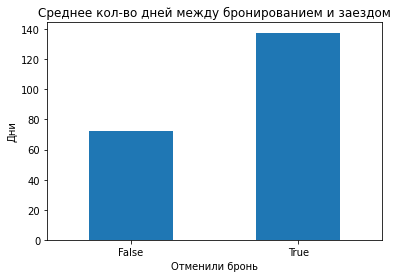

In [62]:
train_data.groupby('is_canceled')['lead_time'].mean().plot(kind='bar', xlabel='Отменили бронь', ylabel='Дни')
plt.title('Среднее кол-во дней между бронированием и заездом')
plt.xticks(rotation=0)
plt.show()

Можно заметить существенную разницу. "Ненадежные" клиенты, в среднем, бронируют номера **сильно заранее (примерно за полгода)**.

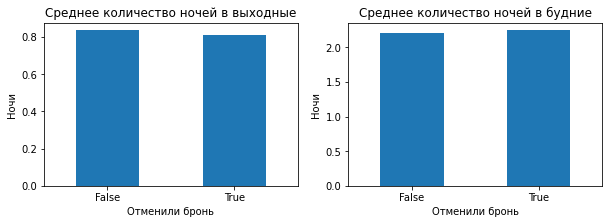

In [63]:
fig, ax = plt.subplots(1, 2)
fig.set_figheight(3)
fig.set_figwidth(10)

train_data.groupby('is_canceled')['stays_in_weekend_nights'].mean().plot(kind='bar', xlabel='Отменили бронь', ylabel='Ночи', 
                                                                         ax=ax[0], title='Среднее количество ночей в выходные')
ax[0].tick_params(axis='x', labelrotation=0)

train_data.groupby('is_canceled')['stays_in_week_nights'].mean().plot(kind='bar', xlabel='Отменили бронь', ylabel='Ночи', 
                                                                      ax=ax[1], title='Среднее количество ночей в будние')
plt.xticks(rotation=0)
plt.show()

По среднему количеству ночей в выходные/будние дни особых отличий не наблюдается.

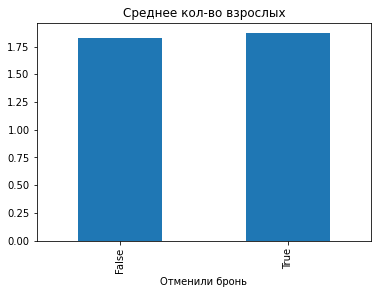

In [64]:
train_data.groupby('is_canceled')['adults'].mean().plot(kind='bar', xlabel='Отменили бронь', title='Среднее кол-во взрослых')
plt.show()

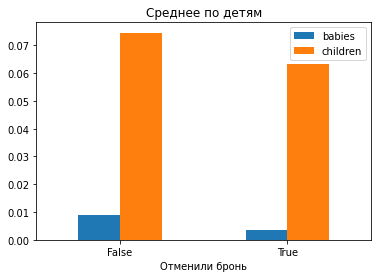

In [65]:
pd.pivot_table(train_data, index='is_canceled', values=['children', 'babies']).plot(kind='bar', xlabel='Отменили бронь')
plt.title('Среднее по детям')
plt.xticks(rotation=0)
plt.show()

В среднем, в номер заселяются по два человека и в том, и другом случае, и зачастую без детей. При этом, клиенты, отменившие бронирование, реже берут с собой детей и тем более младенцев.

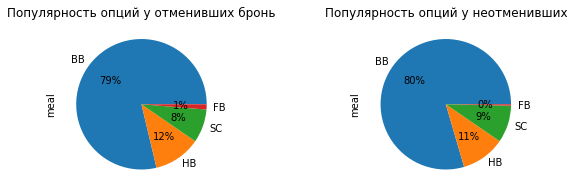

In [66]:
fig, ax = plt.subplots(1, 2)
fig.set_figheight(3)
fig.set_figwidth(10)

train_data.query('is_canceled == True')['meal'].value_counts().plot(kind='pie', autopct='%1.f%%', ax=ax[0],
                                                                    title='Популярность опций у отменивших бронь')

train_data.query('is_canceled == False')['meal'].value_counts().plot(kind='pie', autopct='%1.f%%', ax=ax[1],
                                                                    title='Популярность опций у неотменивших')

plt.show()

Доли клиентов, приходящихся на каждую опцию примерно совпадают. Чаще всего гости предпочитают включать в заказ только завтрак. Менее популярным оказался вариант "все включено" - и завтрак, и обед, и ужин.

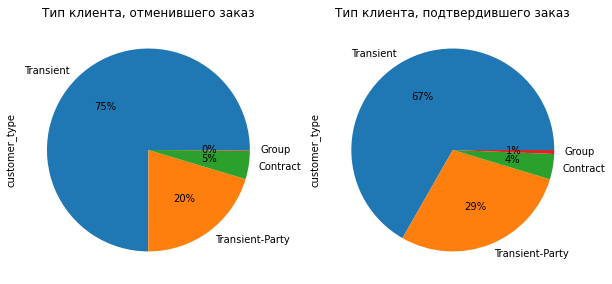

In [67]:
fig, ax = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(10)

train_data.query('is_canceled == True')['customer_type'].value_counts().plot(kind='pie', autopct='%1.f%%', ax=ax[0],
                                                                    title='Тип клиента, отменившего заказ')

train_data.query('is_canceled == False')['customer_type'].value_counts().plot(kind='pie', autopct='%1.f%%', ax=ax[1],
                                                                    title='Тип клиента, подтвердившего заказ')

plt.show()

Соотношение различных типов клиентов также схоже. БОльшая часть посетителей приезжают сами (без договора или группы).

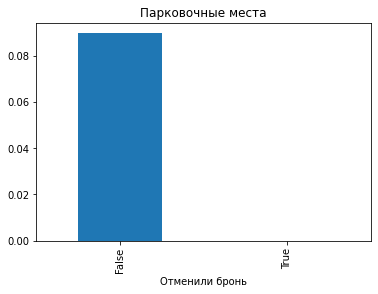

In [68]:
train_data.groupby('is_canceled')['required_car_parking_spaces'].mean().plot(kind='bar', xlabel='Отменили бронь', title='Парковочные места')
plt.show()

Интересно, что 100% клиентов, которые заявили о необходимости парковочного места (хотя бы одного), не отменяли бронирования.

In [69]:
country_pivot = pd.pivot_table(train_data, index='country', values='is_canceled', aggfunc=['mean', 'sum'])
country_pivot.columns = ['mean', 'sum']
country_pivot.sort_values(by=['mean', 'sum'], ascending=False).head(25)
# plt.title('Топ-30 стран по отмене бронирований')
# plt.show()

,mean,sum
country,,
HKG,1.000000,16
TJK,1.000000,8
JEY,1.000000,5
GGY,1.000000,3
GLP,1.000000,2
KHM,1.000000,2
MAC,1.000000,2
AND,1.000000,1
BEN,1.000000,1


Есть страны со 100% отменой бронирования, однако зачастую на них приходится по 1-2 заказа. Однако, можно выделить Гонконг, Объединенные арабские эмираты, Индонезию, а также Португалию. Последняя лидирует по количеству оформленных бронирований, но при этом, больше половины из них отменяются.

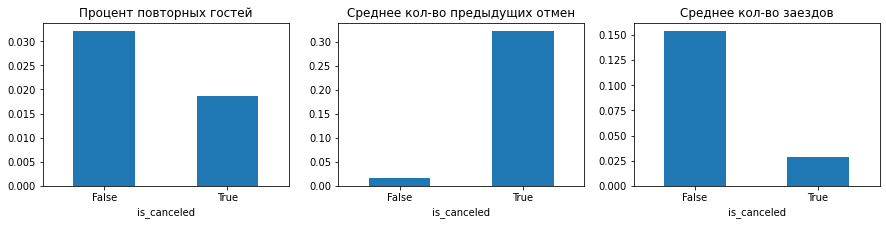

In [70]:
fig, ax = plt.subplots(1, 3)
fig.set_figheight(3)
fig.set_figwidth(15)

train_data.groupby('is_canceled')['is_repeated_guest'].mean().plot(kind='bar', title='Процент повторных гостей', ax=ax[0])
ax[0].tick_params(axis='x', labelrotation=0)

train_data.groupby('is_canceled')['previous_cancellations'].mean().plot(kind='bar', title='Среднее кол-во предыдущих отмен', ax=ax[1])
ax[1].tick_params(axis='x', labelrotation=0)

train_data.groupby('is_canceled')['previous_bookings_not_canceled'].mean().plot(kind='bar', title='Среднее кол-во заездов', ax=ax[2])
ax[2].tick_params(axis='x', labelrotation=0)

plt.show()

Как и ожидалось, среди тех, кто уже был в этом отеле, меньший процент людей отменяет бронирование. При этом, повторные гости, склонные отменить текущую бронь, раньше уже отменяли поездку. 

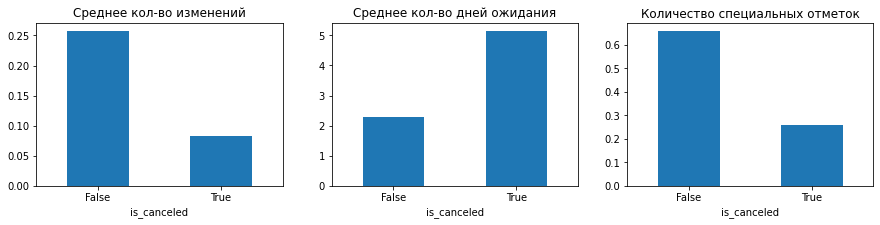

In [71]:
fig, ax = plt.subplots(1, 3)
fig.set_figheight(3)
fig.set_figwidth(15)

train_data.groupby('is_canceled')['booking_changes'].mean().plot(kind='bar', title='Среднее кол-во изменений', ax=ax[0])
ax[0].tick_params(axis='x', labelrotation=0)

train_data.groupby('is_canceled')['days_in_waiting_list'].mean().plot(kind='bar', title='Среднее кол-во дней ожидания', ax=ax[1])
ax[1].tick_params(axis='x', labelrotation=0)

train_data.groupby('is_canceled')['total_of_special_requests'].mean().plot(kind='bar', title='Количество специальных отметок', ax=ax[2])
ax[2].tick_params(axis='x', labelrotation=0)

plt.show()

При этом, люди, склонные действительно заселиться, вносят бОльше изменений и к их бронированию прилагается бОльше специальных отметок (возможно, это взаимосвязанные параметры). При этом, они примерно в два раза быстрее подтверждают заказ.

In [72]:
room_pivot = pd.pivot_table(train_data, index='reserved_room_type', values='is_canceled', aggfunc=['mean', 'sum'])
room_pivot.style.background_gradient(cmap='Greens')

,mean,sum
,is_canceled,is_canceled
reserved_room_type,,
A,0.390615,19721
B,0.299720,214
C,0.188596,43
D,0.305946,2871
E,0.248671,608
F,0.287366,348
G,0.322635,191


Наибольший процент отмен наблюдается для комнат самого высокого класса, на втором месте - самого низкого. При этом, если номера категории А выбирает бОльшая часть посететилей в принципе, то комнаты класса G - менее 200.  

In [73]:
room_pivot = pd.pivot_table(train_data, index='season', values='is_canceled', aggfunc=['mean', 'sum'])
room_pivot.style.background_gradient(cmap='Greens')

,mean,sum
,is_canceled,is_canceled
season,,
Autumn,0.373038,8863
Spring,0.354926,4827
Summer,0.396141,6734
Winter,0.333738,3572


Как можно заменить, самый высокий процент отмен летом, несмотря на то, что бОльшая часть клиентов предпочитает приезжать осенью.

Таким образом, **основные черты "ненадежного" клиента**:
- бронирует номер сильно заранее (в среднем, за полгода)
- с меньшей вероятностью берет с собой детей
- не заявляет о необходимости парковочного места
- скорее всего, ранее здесь не был, а если был - ранее отменял бронирование
- его заказ долго ожидает подтверждения
- в заказ почти не вносятся изменения и специальные отметки

При этом, надо быть внимательным к гостям, приезжающим из "редких" стран, заказывающим номер с самой высокой стоимостью или же наоборот, с самой низкой. В особенности летом, когда наблюдается самый высокий процент отмен.

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! </div>

<a id="conclusion"></a>
### Шаг 6. Напишите общий вывод

В рамках данного исследования предполагалось разработать систему, которая предсказывает отказ от брони номера в отеле. Данные включали в себя два набора - тренировочный (65 тыс. строк) и тестовый (32 тыс.строк), в каждом из которых содержалось по 24 признака и 1 целевой переменной. 

На этапе предобработки данных были удалены некоторые некорректные значения и неявные дубликаты, исправлены несоответствия в типах данных. Тренировочный набор был приведен к виду, подходящему для последующего обучения модели: некоторые признаки были удалены, оставшиеся числовые - стандартизированы, категориальные - закодированы *методом OHE*. 

С учетом задачи, для оценки эффективности модели была предложена метрика recall (полнота), позволяющая оценить долю правильно определенных "ненадежных" клиентов. Из алгоритмов обучения - сравнивались два наиболее известных: *Random Forest* и *Логистическая регрессия*. Самые высокие результаты были получены при обучении модели *случайного леса, включающей 11 деревьев с максимальной глубиной 2*: **recall=0.791**. Т.е. модель успешно определяла 4/5 отмененных брони на тренировочном наборе. На тестовом та же модель показала чуть более низкий результат: **recall=0.664**. Расчеты прибыли До и После подтвердили: внедрение системы депозитов, в основе которой лежала бы данная ML модель, позволит увеличить прибыль отеля на **36%** (10 млн рублей), что с избытком покроет затраты на ее разработку.

Дополнительно, было изучено влияние признаков на отмену брони и составлен "портрет ненадежного клиента". Как оказалось, люди, склонные отменять заказ, стараются бронировать номер заранее, редко берут с собой детей и приезжают на автомобилях. При этом, их заказы долго ожидают подтверждения и нечастно корректируются. Зачастую такие посетители до этого не оформляли бронирования в данном отеле или же уже отменяли их ранее. Отелю следует более внимательно относиться к таким клиентам, особенно, если они бронируют номер летом и приезжают из нечасто встречающихся стран.

<b>Итоговый комментарий ревьюера:</b> Молодец, отличная работа! Возвращаю работу, чтобы у тебя была возможность задать вопросы, если они остались. Так же для улучшения проекта я бы советовал для подбора гиперпараметров использовать GridSearchCV со встроенной кроссвалидацией, а про циклы забыть, как страшный сон. Ниже оставлю пару ссылок для самообучения! Успехов!

<div class="alert alert-success">
<b>Рубрика “Полезные ссылки”:
✅</b> <br>
<a href = "https://sphweb.bumc.bu.edu/otlt/MPH-Modules/PH717-QuantCore/PH717-Module9-Correlation-Regression/PH717-Module9-Correlation-Regression4.html">Коэффициенты корреляции</a><br>
<a href = "https://www.researchgate.net/profile/Paul-Louangrath/post/Ranking_or_scoring_variables_using_conditional_probability/attachment/59d63c45c49f478072ea7c1a/AS%3A273748962283533%401442278246675/download/100+Statistical+Tests.pdf">100 Statistical tests</a><br>
<a href = "https://loginom.ru/blog/missing">Обработка пропусков</a><br>
<a href = "https://coderlessons.com/tutorials/python-technologies/izuchai-siborna/siborn-kratkoe-rukovodstvo"> Seaborn</a><br>
<a href = "https://habr.com/ru/post/502958/"> Plotly</a><br>
<a href = "https://medium.com/@jetbootsmaker/%D0%BF%D0%BE%D0%B2%D1%8B%D1%88%D0%B0%D0%B5%D0%BC-%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D0%BE%D1%81%D1%82%D1%8C-%D0%BF%D1%80%D0%B8-%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B5-%D1%81-jupyter-notebook-81a1cab8bac1"> Повышаем продуктивность при работе с Jupyter</a><br>
<a href = "https://towardsdatascience.com/5-things-you-should-know-about-covariance-26b12a0516f1">5 Things You Should Know About Covariance</a><br>
    <a href = "https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/">Выбросы</a><br>
    <a href = "https://www.kaggle.com/code/baghern/a-deep-dive-into-sklearn-pipelines/notebook">Pipeline</a>
</div>

<div class="alert alert-info"> <b>Комментарий студента:</b> У меня как раз есть парочка вопросов. Я пыталась как раз изначально использовать GridSearchCV и получала ооочень высокие результаты для совсем начальных параметров (recall > 0.85 при одном дереве с глубиной 2, например). При этом, на тестовой выборке оно давало крайне низкие результаты. Т.е. очевидно, модель переобучалась и я не смогла понять почему, поэтому пришлось использовать циклы. Также я пробовала kNN как метод дополнительно рассматривать, но и там наблюдала такую же ситуацию - крайне высокие значения при минимальном количестве соседей (спуск вниз по метрике при увеличении параметра), даже с циклом. Ниже приведу пример ранее написанного кода, подскажите, пожалуйста, что не так. </div>

<b>Итоговый комментарий ревьюера V2:</b> Привет еще раз! Думаю проблема в smote. По хорошему, чтобы избежать утечки в данных, стоит любые модификации данных прописывать в пайплайны. Так же можешь попробовать использовать вместо cv StratifiedKFold, так же можно вместо smote прописать весовые коэффициенты. Кидаю ссылку про использование SMOTE с кроссвалидацией! <a href = "https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7">The right way of using SMOTE with Cross-validation</a> Успехов в дальнейшем обучении!

In [74]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [75]:
def fit_model(model, params):
    grid = GridSearchCV(model, params, scoring='recall', cv=5)
    grid.fit(features_train, target_train)
    results = pd.DataFrame(grid.cv_results_)
    
    return results

In [76]:
%%time

# kNN
model = KNeighborsClassifier()
k_range = list(range(1, 15, 2))
params = dict(n_neighbors=k_range)

knn_results = fit_model(model, params)
display(knn_results.sort_values(by='mean_test_score', ascending=False))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.151043,0.004253,12.889027,0.110027,1,{'n_neighbors': 1},0.773043,0.823329,0.923049,0.956167,0.957263,0.886570,0.074913,1
1,0.151941,0.003916,12.872473,0.039326,3,{'n_neighbors': 3},0.763180,0.806892,0.910142,0.933155,0.932546,0.869183,0.070572,2
2,0.150340,0.003601,12.809273,0.057182,5,{'n_neighbors': 5},0.760745,0.791915,0.901741,0.913795,0.915743,0.856788,0.066602,3
3,0.150916,0.001920,12.922456,0.046962,7,{'n_neighbors': 7},0.760867,0.770364,0.893583,0.905029,0.909412,0.847851,0.067411,4
4,0.150392,0.003584,12.915263,0.038684,9,{'n_neighbors': 9},0.753805,0.768538,0.890052,0.897358,0.898819,0.841714,0.065995,5
5,0.149992,0.003040,13.109784,0.081315,11,{'n_neighbors': 11},0.746865,0.763180,0.885182,0.885791,0.888226,0.833849,0.064576,6
6,0.150601,0.002948,13.297339,0.191989,13,{'n_neighbors': 13},0.747839,0.755753,0.884573,0.877998,0.880920,0.829417,0.063461,7


CPU times: user 7min 36s, sys: 2.37 s, total: 7min 39s
Wall time: 7min 39s


In [77]:
%%time

# Random Forest
model = RandomForestClassifier()
params = {'n_estimators': range (1, 50, 5), 'max_depth': range (1, 12)}

forest_results = fit_model(model, params)
display(forest_results.sort_values(by='mean_test_score', ascending=False).head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.175148,0.003473,0.021170,0.000744,1,6,"{'max_depth': 1, 'n_estimators': 6}",0.922075,0.746865,0.843906,0.799708,0.910873,0.844685,0.066276,1
10,0.132338,0.002526,0.018771,0.001715,2,1,"{'max_depth': 2, 'n_estimators': 1}",0.737368,0.805796,0.790576,0.999756,0.877268,0.842153,0.090591,2
22,0.316727,0.015772,0.028953,0.001688,3,11,"{'max_depth': 3, 'n_estimators': 11}",0.690734,0.755144,0.826373,0.795324,0.862779,0.786071,0.059396,3
107,1.896464,0.103357,0.087277,0.004815,11,36,"{'max_depth': 11, 'n_estimators': 36}",0.700962,0.653963,0.853281,0.859978,0.844637,0.782564,0.087228,4
105,1.407510,0.051426,0.069026,0.004311,11,26,"{'max_depth': 11, 'n_estimators': 26}",0.705223,0.651772,0.854255,0.845732,0.852916,0.781980,0.086216,5


CPU times: user 6min 54s, sys: 36.8 s, total: 7min 31s
Wall time: 7min 32s
